<a href="https://colab.research.google.com/github/beccalunch/adv-ml-playground/blob/main/inside-deep-learning/ch1_dl_intro_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanics of Learning
- Deep learning = subdomain of machine learning, which is a subdomain of artificial intelligence
- Deep learning is hundreds of small algorithms that act as building blocks
- Applying these blocks repeatedly is what makes up the "deep" part of "deep learning"
- Being a good practicioner of deep learning means understanding which building blocks are available and which ones work best for the problem you are trying to solve.

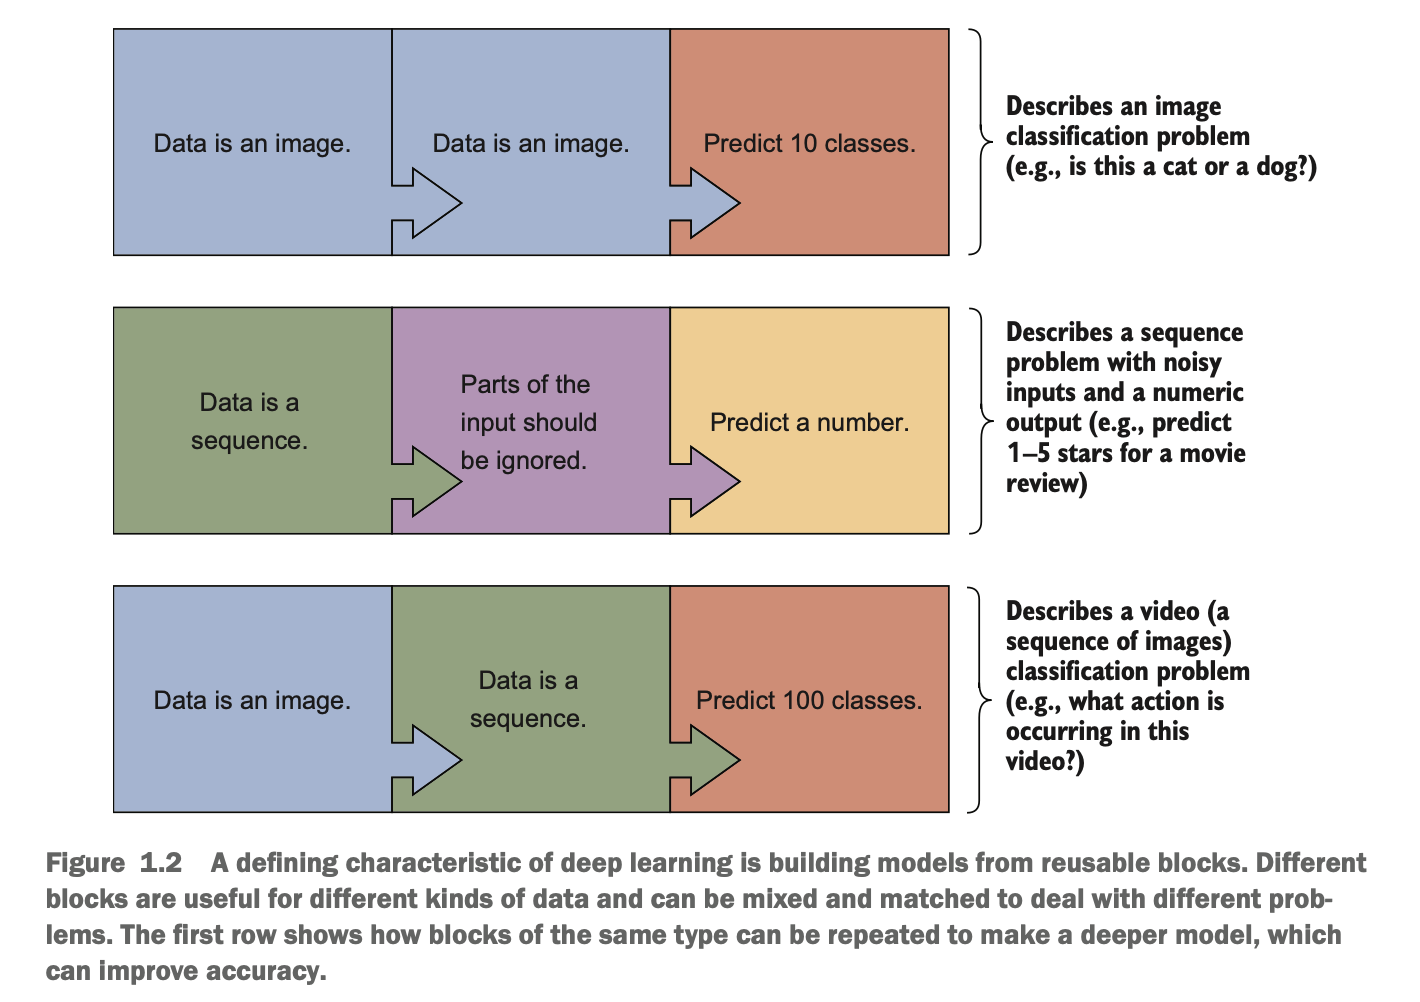

- "Learning" refers to the optimization or function minimization of the functions that make up the building blocks, and the parameters needed to optimize those functions are what is "learned"

# Tensors
- A tensor is a n-dimensional array for any value of n
- It is simply a n-dimensional array upon which PyTorch can perform parallel computation via GPUs, as well as the automatic ability to perform calculus on the object


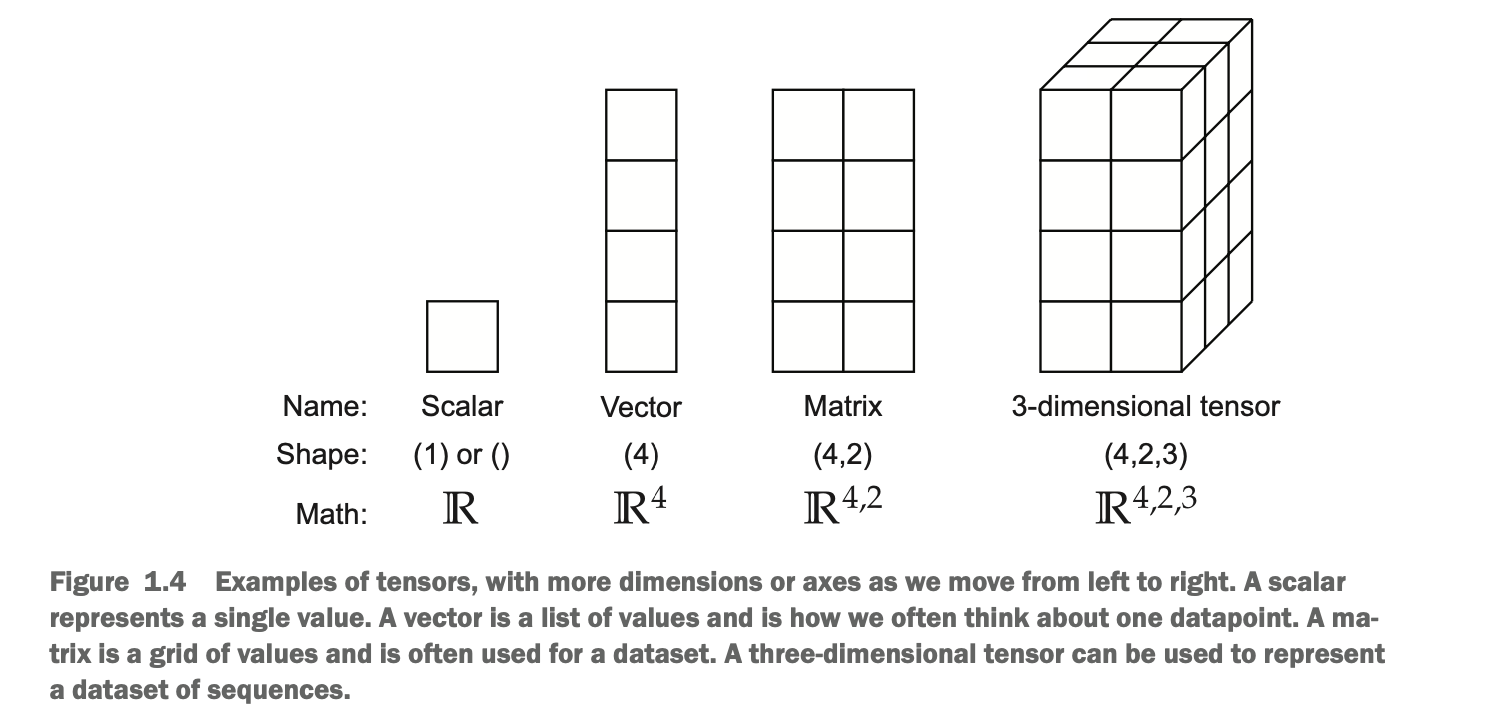

- Slices of tensors can be accessed via "slicing"
  - The ith row of matrix $X$, which would be notated **$x_i$**, could be accessed `x_i = X[i,:]`
- The retrieved slice is still a tensor object, because it is an n-dimensional array

## Tensor shape / size

In [1]:
import torch

torch_scalar = torch.tensor(3.14)
print(torch_scalar)
print(type(torch_scalar))

torch_vector = torch.tensor([1, 2, 3, 4])
print(torch_vector)
print(type(torch_vector))

torch_matrix = torch.tensor([[1, 2,],
                             [3, 4,],
                             [5, 6,],
                             [7, 8,]])
print(torch_matrix)
print(type(torch_matrix))

tensor(3.1400)
<class 'torch.Tensor'>
tensor([1, 2, 3, 4])
<class 'torch.Tensor'>
tensor([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]])
<class 'torch.Tensor'>


In [2]:
print(torch_scalar.shape)
print(torch_vector.shape)
print(torch_matrix.shape)

torch.Size([])
torch.Size([4])
torch.Size([4, 2])


## Numpy
- Numpy objects can be easily converted into Tensors

In [3]:
import numpy as np

x_np = np.random.random((4,4))
print(x_np)

x_pt = torch.tensor(x_np)
print(x_pt)

[[0.08564515 0.23636762 0.65019273 0.17817056]
 [0.23102644 0.55457519 0.55611417 0.9824047 ]
 [0.66002843 0.29180933 0.13828741 0.860469  ]
 [0.96390778 0.12468177 0.16737671 0.69880169]]
tensor([[0.0856, 0.2364, 0.6502, 0.1782],
        [0.2310, 0.5546, 0.5561, 0.9824],
        [0.6600, 0.2918, 0.1383, 0.8605],
        [0.9639, 0.1247, 0.1674, 0.6988]], dtype=torch.float64)


- By default, Numpy uses 64 bit floats and PyTorch uses 32 bit floats, however, if you create a tensor from a Numpy object directly, it will use the same type. This can be seen above.

## Masks
- A master is a tensor that tells us which portion of a tensor are valid to use
- Ex shows a mask that finds every value greater than 0.5 in a tensor

In [4]:
mask = (x_pt > 0.5)
print(mask)
print(mask.dtype)

tensor([[False, False,  True, False],
        [False,  True,  True,  True],
        [ True, False, False,  True],
        [ True, False, False,  True]])
torch.bool


# GPU Acceleration
The key difference between PyTorch and Numpy is PyTorch's ability to leverage GPUs for parallel computation.

When using a GPU, you want to avoid doing compute on small amounts of data due to the overhead caused by I/O. Benchmarking can be done to test a CPU vs GPU performance.

For example, if we want to multiply two matrices $X^{n,m}$ and $Y^{m,p}$ to get a resulting $C^{n,p}$, we can compare the timing using the `timeit` library like so.

In [5]:
import timeit
X = torch.rand(2**10,2**11)
Y = torch.rand(2**11,2**12)

# time the multiplication of them 100 times
time_cpu = timeit.timeit("X@Y", globals=globals(), number=100)
print(time_cpu)

19.18175666799999


We can access the free GPU provided by Colab via the `device` reference in `torch`. If NVIDIA's CUDA drivers are available to us, we can use that as follows.

In [6]:
print("Is CUDA available? :", torch.cuda.is_available())
device = torch.device("cuda")

Is CUDA available? : True


The `to` function can be used to ask PyTorch to move our object to the new GPU device.

In [9]:
X = X.to(device)
Y = Y.to(device)
time_gpu = timeit.timeit("X@Y", globals=globals(), number=100)
print(time_gpu)

0.003443728999968698


Much faster! But we need to keep in mind that this only works if both objects are moved to the same device. Let's see what happens if X is on the GPU and Y remains on the CPU.

In [13]:
Y = torch.rand(2**11,2**12)
time_gpu = timeit.timeit("X@Y", globals=globals(), number=100)
print(time_gpu)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

That is the expected error because we need our variables on the same device.

If we want to move something back to the CPU -- like to turn it into a Numpy array which cannot be done on the GPU -- we can use the `.cpu()` function.

If we want to we can define a function that will allow us to iteratively move lists of objects / tensors onto a device.


In [19]:
def moveTo(obj, device):
  '''
  obj: the python object to move to a device, or to move its
      contents to a device
  device: the compute device to move objects to '''
  if isinstance(obj, list):
      return [moveTo(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(moveTo(list(obj), device))
  elif isinstance(obj, set):
      return set(moveTo(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[moveTo(key, device)] = moveTo(value, device)
      return to_ret
  elif hasattr(obj, 'to'):
      return obj.to(device)
  else:
      return obj


ts = [torch.tensor(1), torch.tensor(2)]
print(ts)
print(moveTo(ts,device))

[tensor(1), tensor(2)]
[tensor(1, device='cuda:0'), tensor(2, device='cuda:0')]


## Automatic Differentiation

Definitions
- We define a derivative colloquially as a measure of how quickly a function $f(x)$ is changing with relation to input $x$.
- $x^*$ is a _minimizer_ of $f(x)$ if it can be said that $f(x^*) \leq f(z)$, $\forall x^* \neq z$
- Derivatives are important because we are typically training a neural network by minimizing a loss function - a quanitifiable measure of how poorly the network is doing at the problem it is trying to solve.
- The loss function is denoted $\ell(x)$ and will always return a scalar
- Gradient = derivative w.r.t. multiple variables

Taking function $f(x) = (x - 2)^2$

<Axes: >

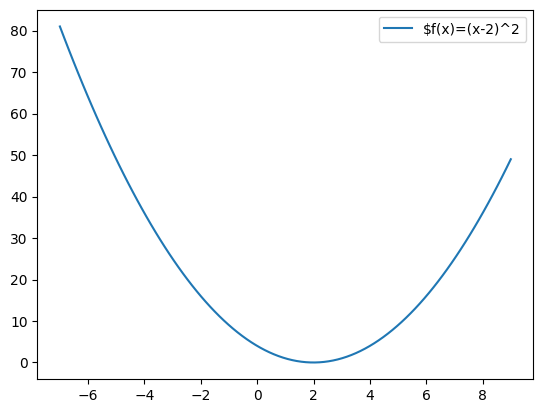

In [20]:
import seaborn as sns

def f(x):
  return torch.pow((x - 2.0), 2)

x_axis = np.linspace(-7,9,100)
y_axis = f(torch.tensor(x_axis)).numpy()

sns.lineplot(x=x_axis, y=y_axis, label='$f(x)=(x-2)^2')


It's trivial to see that the function is minimized at $x=2$ where $f(x)=0$ but let's say we can't plot it.

Take the derivative of the function $f'(x) = 2 * (x - 2) = 2x - 4$

We can plot $f(x)$ and $f'(x)$ simultaneously

<Axes: >

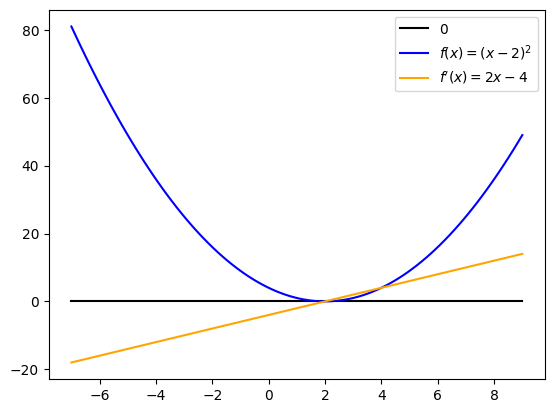

In [22]:
def fP(x):
  return 2 * x - 4

y_axis_p = fP(torch.tensor(x_axis)).numpy()

# draw a black line at 0 to easily visualize sign
sns.lineplot(x=x_axis, y=[0.0]*len(x_axis), label=0, color='black')

# f(x)
sns.lineplot(x=x_axis, y=y_axis, label='$f(x)=(x-2)^2$', color='blue')

# f'(x)
sns.lineplot(x=x_axis, y=y_axis_p, label="$f'(x)=2x-4$", color='orange')


Now we can clearly visualize that $f'(x)=0$ when $x=2$. Note that when $f'(x)$ is positive, we need to decrease $x$ to find the minimizer. Likewise, when $f'(x)$ is negative, we need to increase $x$ to find the minimizer.

This is a nifty visualization to show the fact that the sign of the gradient indicates the direction we need to travel to find the minimizer.

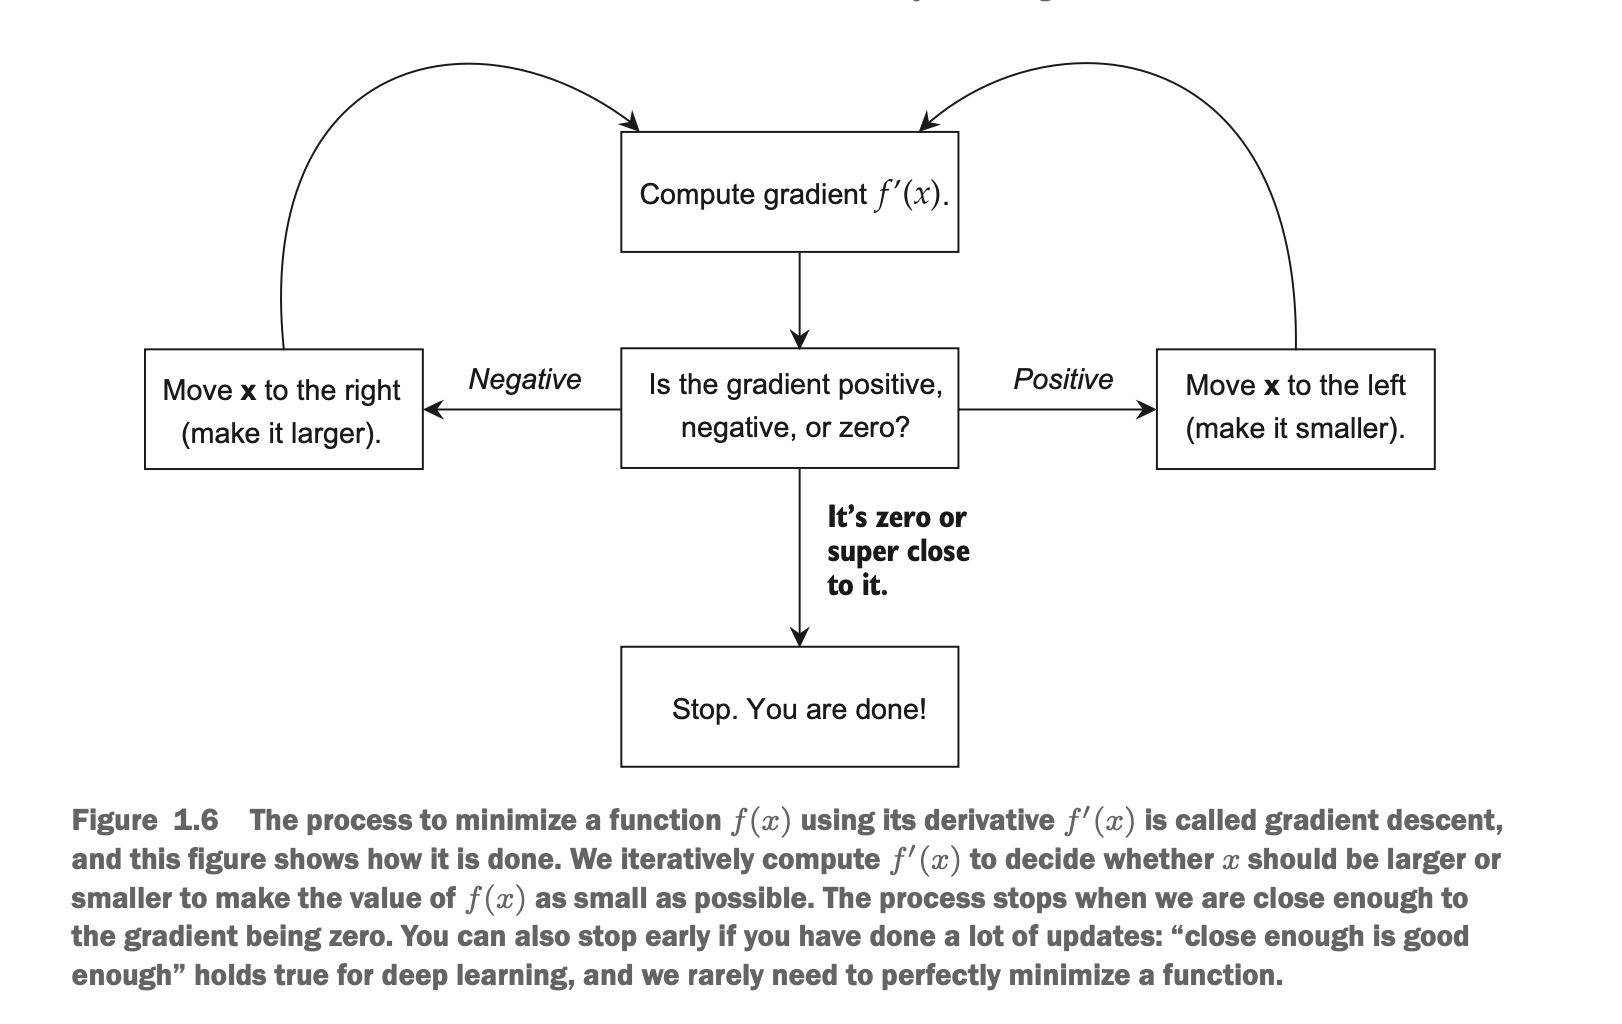

Good news is that we don't actually have to remember calculus, PyTorch will just do this for us.

Let's use the same example function:

In [23]:
def f(x):
  return torch.pow((x - 2.0), 2)


PyTorch can automatically keep track of a gradient at a value, stored in the `grad` variable. Shown below, this variable won't contain anything yet because we haven't yet computed anything.

In [25]:
# define x as a scalar tensor
x = torch.tensor([-3.5], requires_grad=True)
print(x.grad)

None


Because we set `requires_grad=True` when defining `x`, the gradient will be automatically tracked when we compute $f(x)$ here

In [26]:
value = f(x)
print(value)

tensor([30.2500], grad_fn=<PowBackward0>)


We can now tell PyTorch to go back and use the information to calculate a gradient. When we do this with the `backward` function, we then see the gradient populate the original object `x`.

In [27]:
value.backward()
print(x.grad)

tensor([-11.])


### Minimizing a function with derivatives
Knowing PyTorch can automatically compute gradients, we can use it to numerically find the minimizer of any function.

Conceptually, we start with an initial guess and move in the opposite direction of the gradient. The size of the step we move is partially determined by the _learning rate_ $\eta$. The iteration mathematically looks like $x_{\text{cur}} = x_{\text{cur}} - \eta * f'(x_{\text{cur}})$

Below we see examples of a learning rate that is slower than necessary, exactly right, and too big (where we will never converge on a solution), respectively.


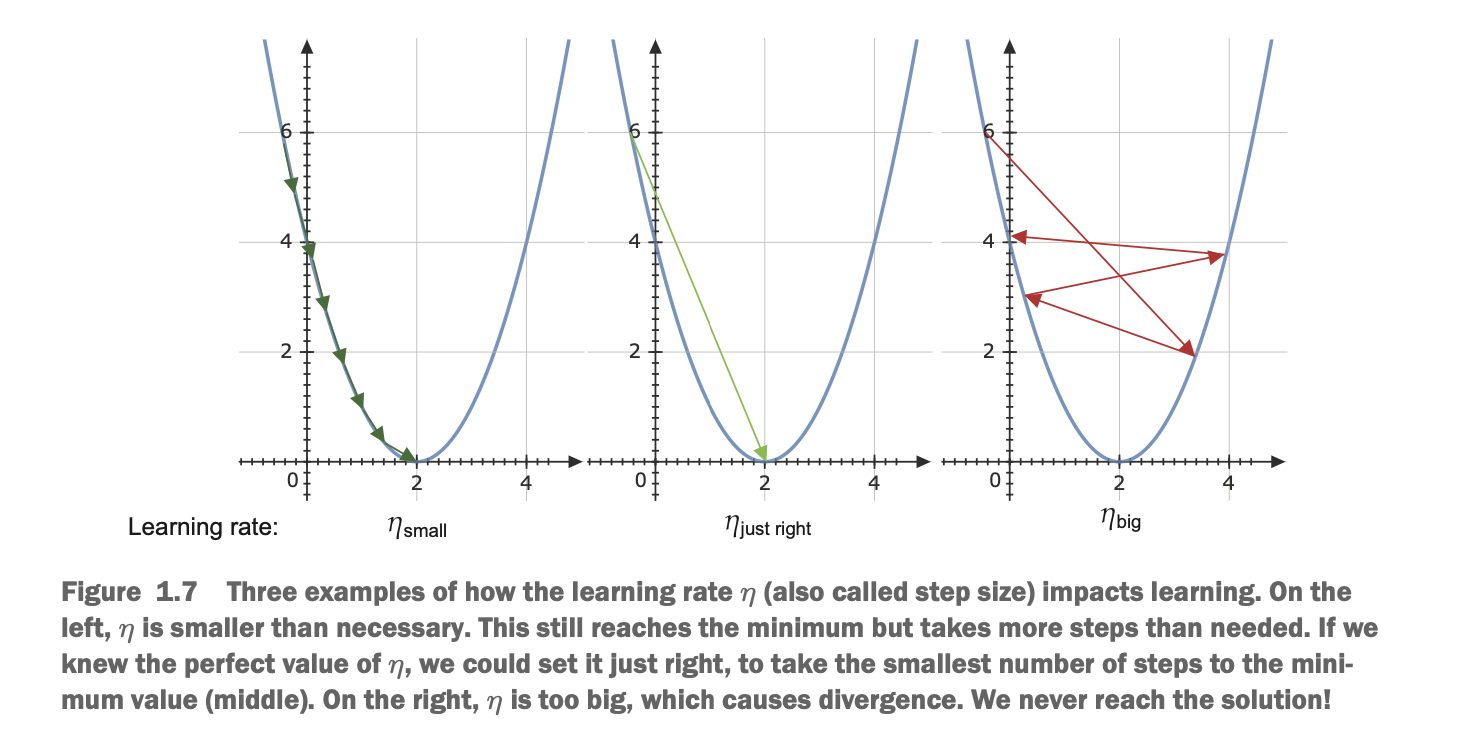